In [35]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ

from lib.file.ROI_reader import ROIFileReader
from lib.analysis.laminar_dist import LaminarROI, Line
from lib.analysis.align import ImageAlign
from lib.utilities import *

####################################################################################
#    Build a hw vs dist scatter and amp vs dist scatter for all high-SNR px for all
#       of Kate's data
####################################################################################

In [5]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/"

enable_photoZ_interaction = True
initialize_photoZ = True
snr_cutoff_signal = 5.0

In [6]:
# set up PhotoZ (open it manually)
if enable_photoZ_interaction:
    aPhz = AutoPhotoZ(data_dir=data_dir)
    if initialize_photoZ:
        aPhz.prepare_photoZ()
pa.alert("Load your ROIs before continuing.")

'OK'

In [9]:
# extract all hw and amp files 
for subdir, dirs, files in os.walk(data_dir):
    for zda_file in files:
        if zda_file.endswith('.zda'):
            zda_filepath = subdir + "/" + zda_file
            print(zda_filepath)
            if enable_photoZ_interaction:
                aPhz = AutoPhotoZ(data_dir=subdir)
                # open the PhotoZ file
                aPhz.select_PhotoZ()

                print("\n\nOpening", zda_file)
                aPhz.open_zda_file(zda_filepath)

                # save SNR values from PhotoZ
                snr_filename = subdir + "/" + "SNR.dat"
                if enable_photoZ_interaction:
                    aPhz.select_SNR_trace_value()
                    aPhz.save_trace_values(snr_filename)

                # save half-width values from PhotoZ
                hw_filename = subdir + "/" + "hw.dat" 
                if enable_photoZ_interaction:
                    aPhz.select_half_width_trace_value()
                    aPhz.save_trace_values(hw_filename)

                # save latency values from PhotoZ
                amp_filename = subdir + "/" + "amp.dat"
                if enable_photoZ_interaction:
                    aPhz.select_maxamp_trace_value()
                    aPhz.save_trace_values(amp_filename)


C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-13_02-01-02_L4_intralaminar/02_01_02.zda


Opening 02_01_02.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-28_03-01-08_aka_02-01-08_L23_intralaminar/02_01_08.zda


Opening 02_01_08.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-28_04-01-01_aka_03-01-01_L4_interlaminar/03_01_01.zda


Opening 03_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-28_06-01-01_aka_part2_03-01-01_L4_interlaminar/03_01_01.zda


Opening 03_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-28_08-01-04_aka_part2_05-01-04_L4_interlaminar/05_01_04.zda


Opening 05_01_04.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-28_10-01-01_aka_part2_07-01-01_L4_interlaminar/07_01_01.zda


Opening 07_01_01.zd



Opening 06_01_01.zda


In [52]:
# for each subdir, take all hw/amp/electrode dist of points with SNR > cutoff
def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Diode Number',  'Value'])
    return data_arr
    
concat_data = pd.DataFrame({})
snr_dfs = []
total_before_filter = 0
for subdir, dirs, files in os.walk(data_dir):
    if subdir.endswith("hw_and_amp_scatter/"):
        continue
    amp = read_dat_trace_file(subdir + "/" + 'amp.dat')
    hw = read_dat_trace_file(subdir + "/" + 'hw.dat')
    snr = read_dat_trace_file(subdir + "/" + 'SNR.dat')
    
    total_before_filter += len(amp['Value'])
    
    snr = snr.join(amp, rsuffix='amp')
    snr = snr.join(hw, rsuffix='hw')
    
    # open stim point roi as a single integer (its diode number) in variable stim_pt
    sp_file = subdir + "/" + 'electrode.dat'
    with open(sp_file, 'r') as f:
        lines = f.readlines()
    stim_pt = int(lines[-1]) # last line is always electrode location
    aux_obj = LaminarROI([stim_pt]).get_points()
    stim_pt = aux_obj[0]  # should be a list of len 2, representing px location [x, y]
    
    snr = snr[pd.to_numeric(snr.Value, errors='coerce').notnull()]
    snr = snr[snr['Value'] > snr_cutoff_signal / 1000]
    
    snr = snr[snr['Valuehw'] > 0]
    snr = snr[snr['Valueamp'] > 0]
    
    
    # Find distance from diode number to stim_pt
    dist = []
    for dn in snr['Diode Number']:
        px = LaminarROI([dn]).get_points()[0]
        d = Line(stim_pt, px).get_length()
        dist.append(d * 6)  # convert px -> um
    
    snr.insert(4, 'electrode_dist', dist)
    
    snr_dfs.append(snr)
    
all_snr = pd.concat(snr_dfs)
print(total_before_filter)
all_snr = all_snr[all_snr['electrode_dist'] > 50]
all_snr

4888


,Diode Number,Value,Diode Numberamp,Valueamp,electrode_dist,Diode Numberhw,Valuehw
28,5130,0.005597,5130,0.005597,173.170436,5130,2.73816
33,1691,0.005036,1691,0.005036,340.945743,1691,4.10435
51,1132,0.005423,1132,0.005423,375.898923,1132,2.34113
10,2897,0.005407,2897,0.005407,118.338498,2897,3.86444
32,1850,0.006172,1850,0.006172,206.891276,1850,3.68861
...,...,...,...,...,...,...,...
50,738,0.005678,738,0.005678,412.911613,738,7.71569
51,1132,0.005230,1132,0.005230,412.082516,1132,3.80646
82,1056,0.005877,1056,0.005877,401.058599,1056,3.57508
32,1850,0.005279,1850,0.005279,373.448792,1850,4.71737


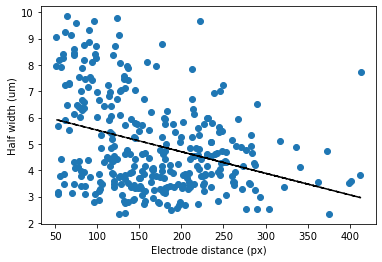

In [53]:
# scatter plot: hw vs electrode dist
x = all_snr['electrode_dist']
plt.scatter(x, all_snr['Valuehw'])
coef = np.polyfit(x, all_snr['Valuehw'], 1)
poly1d_fn = np.poly1d(coef) 
plt.plot(x, poly1d_fn(x), '--k', label='Slope:' + str(coef[1])[5])
plt.xlabel("Electrode distance (px)")
plt.ylabel("Half width (um)")
plt.show()

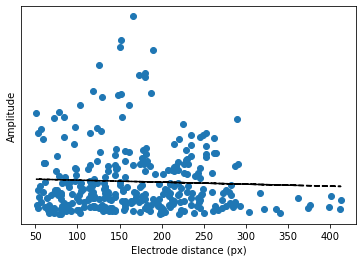

In [55]:
# scatter plot: amp vs electrode dist
plt.scatter(all_snr['electrode_dist'], all_snr['Valueamp'])
coef = np.polyfit(x, all_snr['Valueamp'], 1)
poly1d_fn = np.poly1d(coef) 
plt.plot(x, poly1d_fn(x), '--k', label='Slope:' + str(coef[1])[5])
plt.xlabel("Electrode distance (px)")
plt.ylabel("Amplitude")
plt.yticks([])
plt.show()

In [ ]:
for subdir, dirs, files in os.walk(data_dir):
    zda_files = []
    roi_files = {}  # map slice number to ROIs file
    
    if 'selected_zda' not in subdir:
        continue
    
    # locate important file names
    for f in files:
        if f.endswith(".zda"):
            zda_files.append(f)
        if 'slice' in f[-17:] and f.endswith('_rois.dat'):
            slice_no = int(f.split("_rois.dat")[0][-1])
            roi_files[slice_no] = f
    
    if len(roi_files) < 1 or len(zda_files) < 1:
        continue
    
    for zda_file in zda_files:
        rec_id = zda_file.split('.')[0]
            
        # determine date and slice, loc, rec
        
        aPhz = AutoPhotoZ(data_dir=subdir)
        
        # open the PhotoZ file
        if enable_photoZ_interaction:
            aPhz.select_PhotoZ()
            
            aPhz.open_zda_file(subdir + "/" + zda_file)
        
        date = subdir.split("selected_zda")[0][-9:-1]
        date = [int(x) for x in date.split("-")]
        date[2] += 2000  # full year format
        date = "/".join([str(d) for d in date])
        
        slice_no = int(rec_id.split("_")[0])
        roi_file = roi_files[slice_no]
        print("\n\nscraping data from ", zda_file, "using", roi_file, "on date:", date)

        filename_end = "_" + rec_id + '.dat'

        # open roi file in photoZ
        if enable_photoZ_interaction:
            aPhz.select_roi_tab()
            aPhz.open_roi_file(roi_file)

        # save latency values from PhotoZ
        latency_filename = subdir + "/" + "latency_" + filename_end
        if enable_photoZ_interaction:
            aPhz.select_latency_trace_value()
            aPhz.save_trace_values(latency_filename)

        # save SNR values from PhotoZ
        snr_filename = subdir + "/" + "SNR_" + filename_end
        if enable_photoZ_interaction:
            aPhz.select_SNR_trace_value()
            aPhz.save_trace_values(snr_filename)


        # take JPG photo of ROIs so we know which measurements go where.
        rois_frame_filename = subdir + "/" + "ROIs_" + rec_id + ".jpg"
        if enable_photoZ_interaction:
            aPhz.save_map_jpeg(rois_frame_filename)

        intermed_files = [latency_filename, snr_filename, rois_frame_filename]
        column_groups = [
            ['L4 barrel 1 Latency', 'L4 barrel 2 Latency', 'L4 barrel 3 Latency'],
            ['L4 barrel 1 SNR', 'L4 barrel 2 SNR', 'L4 barrel 3 SNR'],
            ['ROI jpg']
        ]
        
        # look up stim location, age, sex, infusion from cell_type_prefix_all.csv
        ref_row = reference_df[reference_df["Date"] == date][ref_cols]        
        new_row = {"Date" : date, 
                   "Slice/Loc/Rec": rec_id}
        for col in ref_cols:
            new_row[col] = ref_row.iloc[0][col]
        
        # open these various files and store them to the pandas dataframe
        # The first three ROIs of each should correspond to the 3 desired barrel ROIs
        # each barrel/value pair is a column in the target CSV
        for j in range(len(intermed_files)):
            if intermed_files[j].endswith(".dat"):
                intermed_df = pd.read_csv(intermed_files[j],
                                          sep='\t',
                                          header=None,
                                          names=['Index',  'Values'])
                for i in range(len(column_groups[j])):
                    lat_val = intermed_df['Values'][i]
                    new_row[column_groups[j][i]] = lat_val
            else:  # .jpg, store link as csv value
                new_row[column_groups[j][0]] = intermed_files[j]
        print(new_row)
        df = df.append(new_row, ignore_index=True)


In [ ]:
# compute statistics on barrel pairs:
#    1) whether delta latency should be considered based on SNR
#    2) Delta latency between L4 barrels (b1 - b2, b3 - b2)
df['Delta latency 1 (barrel 1 - barrel 2)'] = df['L4 barrel 1 Latency'] - df['L4 barrel 2 Latency']
df['Delta latency 2 (barrel 3 - barrel 2)'] = df['L4 barrel 3 Latency'] - df['L4 barrel 2 Latency']

# if either barrel 1 or barrel 2 has low SNR, don't compute the delta latency between these two
df.loc[(df['L4 barrel 1 SNR'] < snr_cutoff_signal) | (df['L4 barrel 2 SNR'] < snr_cutoff_signal),
       'Delta latency 1 (barrel 1 - barrel 2)'] = None

# same for barrel 2 or barrel 3
df.loc[(df['L4 barrel 3 SNR'] < snr_cutoff_signal) | (df['L4 barrel 2 SNR'] < snr_cutoff_signal),
       'Delta latency 2 (barrel 3 - barrel 2)'] = None

for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    print("Barrel pairs in", stim_loc)
    # count number of barrel pairs with no signal crossing
    n_barrel_no_cross = len(df2[(df2['L4 barrel 1 SNR'] < snr_cutoff_signal) & 
                               (df2['L4 barrel 2 SNR'] > snr_cutoff_signal)])
    n_barrel_no_cross += len(df2[(df2['L4 barrel 2 SNR'] < snr_cutoff_signal) & 
                                (df2['L4 barrel 1 SNR'] > snr_cutoff_signal)])
    n_barrel_no_cross += len(df2[(df2['L4 barrel 2 SNR'] < snr_cutoff_signal) & 
                                (df2['L4 barrel 3 SNR'] > snr_cutoff_signal)])
    n_barrel_no_cross += len(df2[(df2['L4 barrel 3 SNR'] < snr_cutoff_signal) & 
                                (df2['L4 barrel 2 SNR'] > snr_cutoff_signal)])
    print("\t", n_barrel_no_cross, "no crossing out of", len(df2) * 2, "in layer", stim_loc)

    # count number of barrel pairs with signal crossing
    n_barrel_cross = len(df2[(df2['L4 barrel 1 SNR'] > snr_cutoff_signal) & 
                            (df2['L4 barrel 2 SNR'] > snr_cutoff_signal)])
    n_barrel_cross += len(df2[(df2['L4 barrel 2 SNR'] > snr_cutoff_signal) & 
                             (df2['L4 barrel 3 SNR'] > snr_cutoff_signal)])
    print("\t", n_barrel_cross, "crossing out of", len(df2) * 2, "in layer", stim_loc)

    # count number of barrel pairs with no signal
    n_barrel_none = len(df2[(df2['L4 barrel 1 SNR'] < snr_cutoff_signal) & 
                            (df2['L4 barrel 2 SNR'] < snr_cutoff_signal)])
    n_barrel_none += len(df2[(df2['L4 barrel 2 SNR'] < snr_cutoff_signal) & 
                             (df2['L4 barrel 3 SNR'] < snr_cutoff_signal)])
    print("\t", n_barrel_none, "no signal out of", len(df2) * 2, "in layer", stim_loc)

In [ ]:
df['abs(delta 1)'] = np.abs(df['Delta latency 1 (barrel 1 - barrel 2)'])
df['abs(delta 2)'] = np.abs(df['Delta latency 2 (barrel 3 - barrel 2)'])



for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    dfd1 = df2['abs(delta 1)'].dropna()
    dfd2 = df2['abs(delta 2)'].dropna()

    print("Latency between barrel pairs in", stim_loc)
    dfds = np.concatenate([dfd1, dfd2])
    print("\t", 
          str(np.mean(dfds))[:5], 
          "+/-", 
          str(np.std(dfds))[:5], 
          "(n =", 
          str(len(dfds)) + ")")
    print("\t", dfds)

In [ ]:
# write the pandas dataframe back to csv
csv_filename = cell_type_prefix + '_all_slices-edited.csv'
df.to_csv(data_dir + csv_filename, index=False)

In [ ]:
df